In [1]:
import utils
import matplotlib.pyplot as plt
import numpy as np

number of common Subjects  171


In [2]:
np.__version__

'1.23.5'

In [3]:
data,mask,scan,gtab,grad = utils.load_hcp('130114','3T',crop = 30)

In [4]:
data_mean = utils.mean_volume(data,gtab,5)

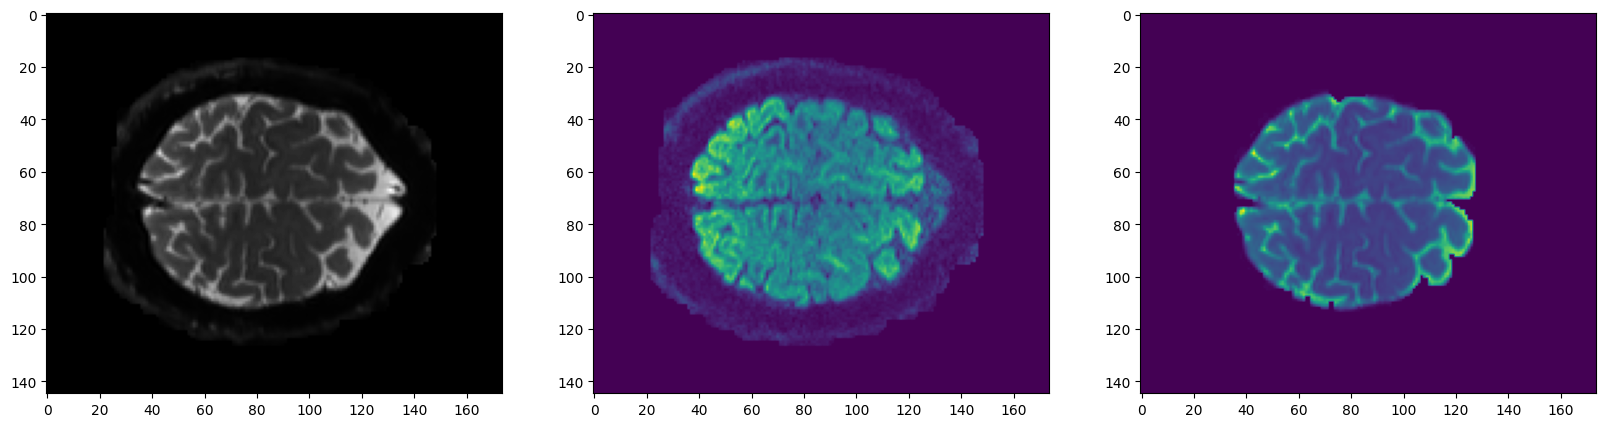

In [5]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].imshow(data_mean[:,:,i],cmap='gray')
axis[1].imshow(data[:,:,i,1])
axis[2].imshow(mask[:,:,i]*data_mean[:,:,i])

## Ground Truth
* Diffusion image with all volumes
* b0 in this case is mean of all b = 5 volumes
* dwis contains all other volumes along with bvecs and bvals to compute apparent diffusion coefficients

In [6]:
dwis = data[:,:,:,np.where(gtab.bvals>5)].squeeze()
b0 = utils.mean_volume(data,gtab,5)
bvals = gtab.bvals[np.where(gtab.bvals>5)]
bvecs = gtab.bvecs[np.where(gtab.bvals>5)]
dwis_gt,tensor_gt = utils.diff_coefficent(dwis,b0,bvecs,bvals,shp = data.shape,bval_synth = 1000)
dti_gt = utils.dtimetric(tensor_gt, mask);

/home/arihant/DWI_SR/HCP_SR/utils.py:147: RuntimeWarning: divide by zero encountered in divide
  adcs = np.log(1e-3+(dwis / b0)); # s = b0 * exp(-b * adc)
/home/arihant/DWI_SR/HCP_SR/utils.py:147: RuntimeWarning: invalid value encountered in divide
  adcs = np.log(1e-3+(dwis / b0)); # s = b0 * exp(-b * adc)
/home/arihant/DWI_SR/HCP_SR/utils.py:166: RuntimeWarning: overflow encountered in exp
  dwis_norm = np.exp(-bval_synth * (amatrix(dsm_norm) @ tensor_vec))
/home/arihant/DWI_SR/HCP_SR/utils.py:168: RuntimeWarning: invalid value encountered in multiply
  dwis = b0 * dwis_norm.T.reshape(shp[0],shp[1],shp[2], dwis_norm.shape[0]);


In [7]:
dwis_gt[:,:,i,2].max()

3838.6290521997375

In [8]:
dwis_gt[:,:,i,2].min()

0.0

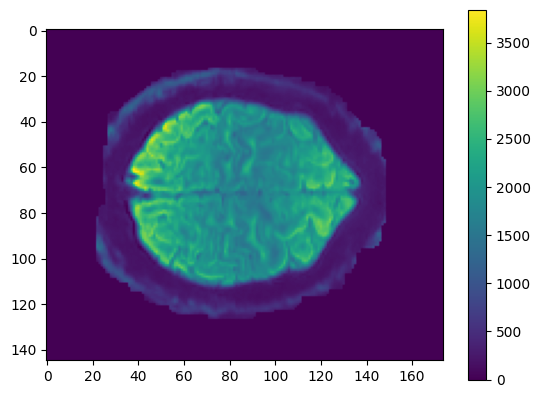

In [13]:
plt.imshow(dwis_gt[:,:,i,2])
plt.colorbar()

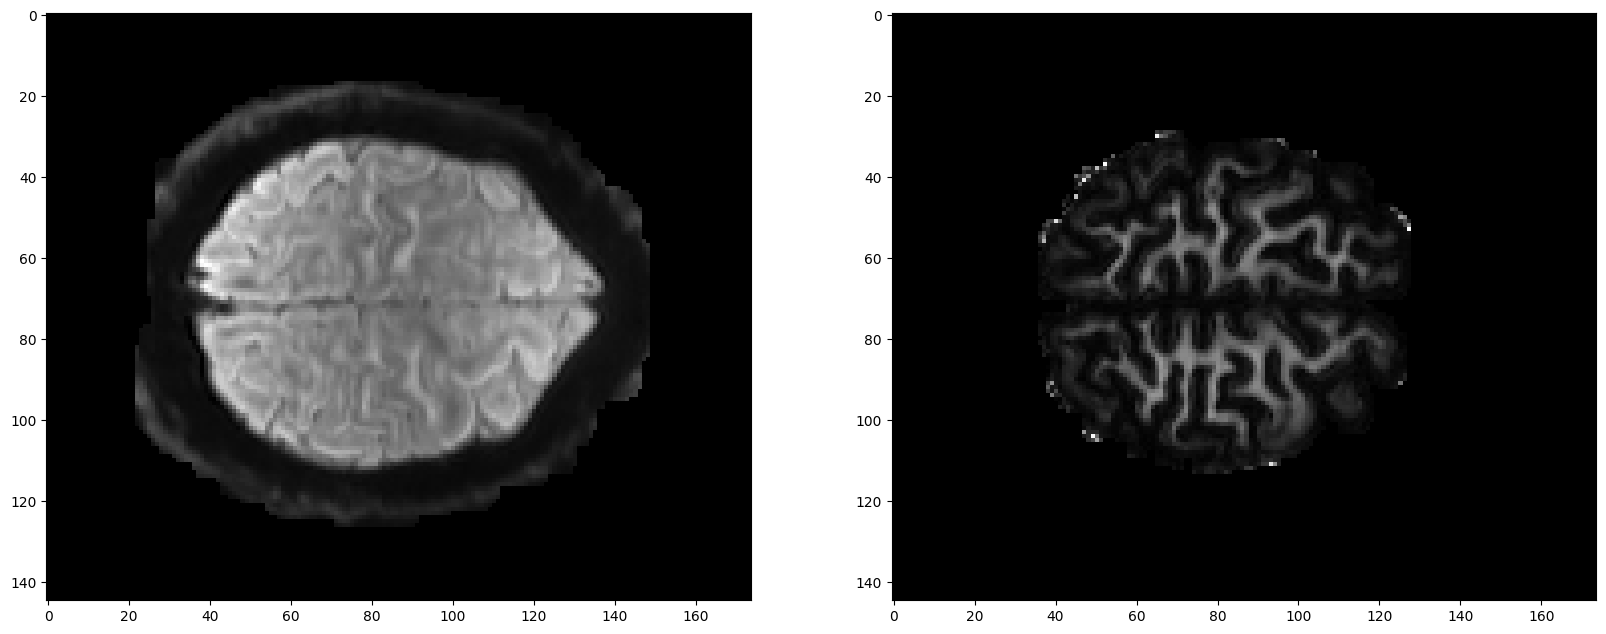

In [10]:
i=70
f, axis = plt.subplots(1, 2)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].imshow(dwis_gt[:,:,i,2],cmap='gray')
axis[1].imshow(dti_gt['fa'][:,:,i],cmap='gray')

## DSM thingy

* Generate data for CNN
* Next step we compute for optimal direction from the vectors in bvecs
* This returns a list of index which are the volume from the original data which correspond to the lowest condition number
* This list is used in the next step using the same function to compute the apparent diffusion coefficients

In [14]:
idx = utils.optimal_dirs(gtab,10000,5,debug = True,base_bval = 5)

/home/arihant/DWI_SR/HCP_SR/utils.py:188: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


Lowest Condition Number :  [1.40995166 1.41711997 1.43353753 1.43456677 1.43744881]


In [15]:
bval_synth = 1000;
input_all = []
tensor_all = []
b0s = data[:,:,:,np.where(gtab.bvals==5)].squeeze()

for i in range(5):
    b0 = b0s[:,:,:,i]
    dwis6 =  dwis[:,:,:,idx[i]]
    bvals6 = bvals[idx[i]]
    bvecs6 = bvecs[idx[i]]
    dwis_pred,tensor_pred = utils.diff_coefficent(dwis6,b0,bvecs6,bvals6,shp = data.shape,bval_synth = 1000)
    dti = utils.dtimetric(tensor_pred, mask);
    tensor_all.append(tensor_pred)
    input_all.append(dwis_pred)
    
    

/home/arihant/DWI_SR/HCP_SR/utils.py:147: RuntimeWarning: divide by zero encountered in divide
  adcs = np.log(1e-3+(dwis / b0)); # s = b0 * exp(-b * adc)
/home/arihant/DWI_SR/HCP_SR/utils.py:147: RuntimeWarning: invalid value encountered in divide
  adcs = np.log(1e-3+(dwis / b0)); # s = b0 * exp(-b * adc)
/home/arihant/DWI_SR/HCP_SR/utils.py:166: RuntimeWarning: overflow encountered in exp
  dwis_norm = np.exp(-bval_synth * (amatrix(dsm_norm) @ tensor_vec))
/home/arihant/DWI_SR/HCP_SR/utils.py:168: RuntimeWarning: invalid value encountered in multiply
  dwis = b0 * dwis_norm.T.reshape(shp[0],shp[1],shp[2], dwis_norm.shape[0]);
/home/arihant/DWI_SR/HCP_SR/utils.py:120: RuntimeWarning: invalid value encountered in double_scalars
  FA = np.sqrt(sum((D-MD) ** 2)) / np.sqrt(sum(D**2)) * np.sqrt(1.5)


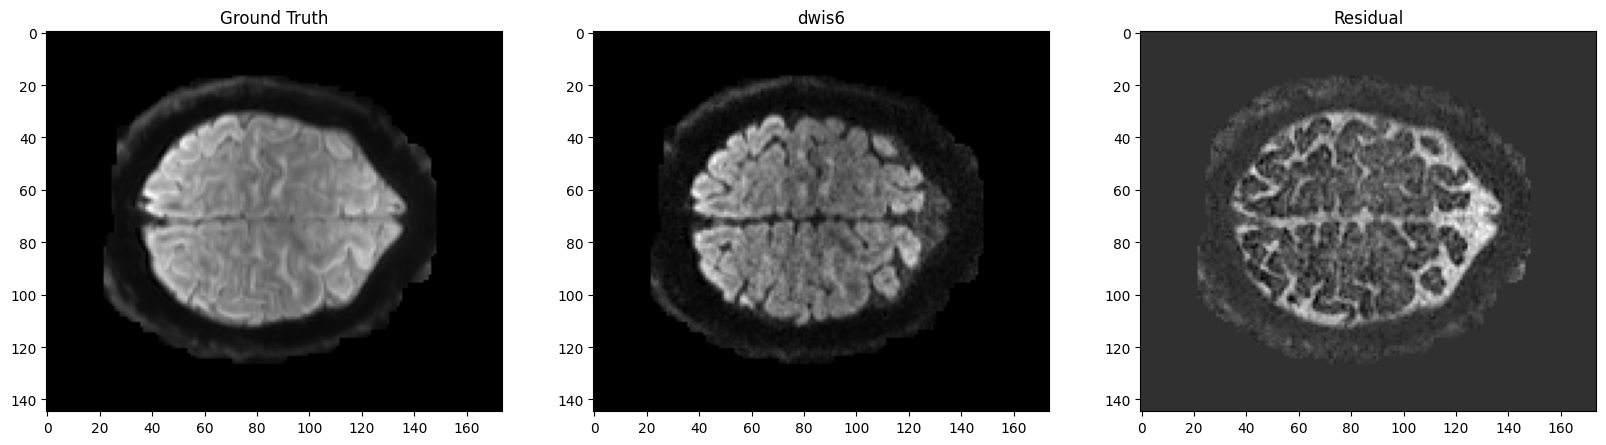

In [16]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].set_title('Ground Truth')
axis[0].imshow(dwis_gt[:,:,i,2],cmap='gray')
axis[1].set_title('dwis6')
axis[1].imshow(input_all[1][:,:,i,2],cmap='gray')
axis[2].set_title('Residual')
axis[2].imshow(dwis_gt[:,:,i,2] - input_all[1][:,:,i,2],cmap='gray')

## Model

In [17]:
import os
import scipy.io as sio
import numpy as np
from matplotlib import pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [18]:
import qtlib as qtlib
from dncnn import dncnn_model


In [22]:
diff_gt = dwis_gt
diff_input1 = input_all[0]
diff_input2 = input_all[1]
diff_input3 = input_all[2]
diff_input4 = input_all[3]
diff_input5 = input_all[4]
mask = mask

# concatenate input data
diff_input1 = np.expand_dims(diff_input1, 4) # input in this example do not contain t1w and t2w data, can simply concatenate them with the several diffusion images
diff_input2 = np.expand_dims(diff_input2, 4)
diff_input3 = np.expand_dims(diff_input3, 4)
diff_input4 = np.expand_dims(diff_input4, 4)
diff_input5 = np.expand_dims(diff_input5, 4)   
diff_input = np.concatenate((diff_input1, diff_input2, diff_input3, diff_input4, diff_input5), axis=4)

# %% standardize image intensity

diff_input_stand = np.zeros(diff_input.shape)
diff_output_stand = np.zeros(diff_input.shape)

for ii in np.arange(0, diff_input.shape[-1]):   

    imgs_in = diff_input[:, :, :, :, ii]
    imgs_out = diff_gt

    imgs_in_stand = np.zeros(imgs_in.shape)
    imgs_out_stand = np.zeros(imgs_out.shape)

    for jj in np.arange(0, imgs_in.shape[-1]):  
        
        img = imgs_in[:, :, :, jj];
        imgmean = np.mean(img[np.nonzero(mask)])
        imgstd = np.std(img[np.nonzero(mask)])
        
        imgs_in_stand[:, :, :, jj] = (img - imgmean) / imgstd * mask; # normalize by substracting mean then dividing the std dev of brain voxels in input images
        imgs_out_stand[:, :, :, jj] = (imgs_out[:, :, :, jj] - imgmean) / imgstd * mask;
    
    diff_input_stand[:, :, :, :, ii] = imgs_in_stand;
    diff_output_stand[:, :, :, :, ii] = imgs_out_stand;
  
res_output_stand = diff_output_stand - diff_input_stand; # residual btw input and output

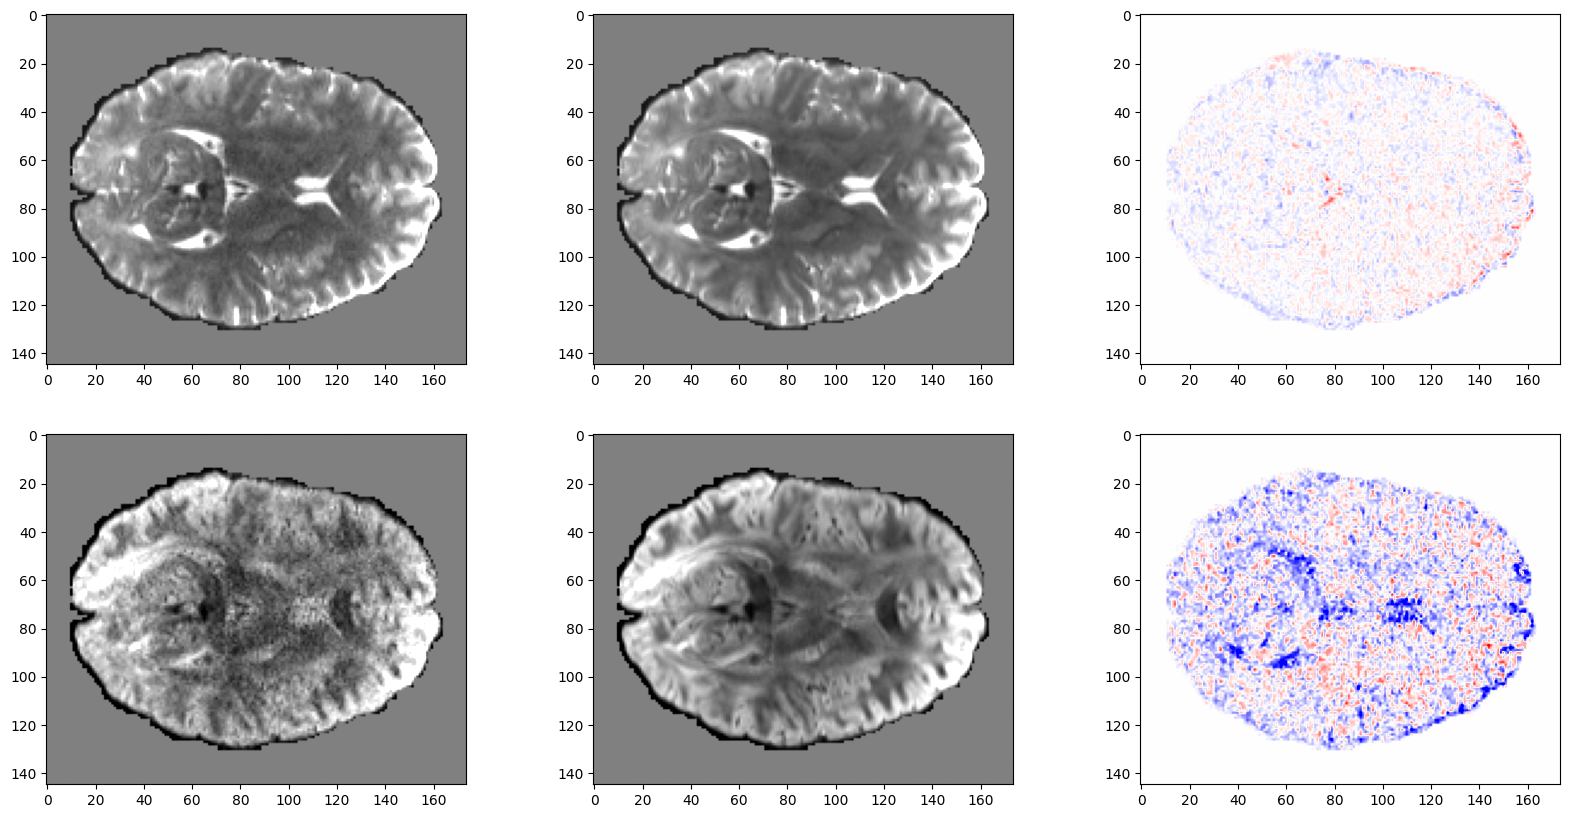

In [21]:
i=70
f, axis = plt.subplots(2, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0][0].imshow(diff_input_stand[:, :, 35, 0, 3], clim=(-2., 2.), cmap='gray')
axis[0][1].imshow(diff_output_stand[:, :, 35, 0, 3], clim=(-2., 2.), cmap='gray')
axis[0][2].imshow(res_output_stand[:, :, 35, 0, 3], clim=(-1., 1.), cmap='bwr')
axis[1][0].imshow(diff_input_stand[:, :, 35, 1, 3], clim=(-2., 2.), cmap='gray')
axis[1][1].imshow(diff_output_stand[:, :, 35, 1, 3], clim=(-2., 2.), cmap='gray')
axis[1][2].imshow(res_output_stand[:, :, 35, 1, 3], clim=(-1., 1.), cmap='bwr')

In [23]:
# %% divide brain volume to blocks

# find indices of smallest block that covers whole brain
tmp = np.nonzero(mask);
xind = tmp[0] * 1.0;
yind = tmp[1] * 1.0;
zind = tmp[2] * 1.0;

xmin = np.min(xind); xmax = np.max(xind);
ymin = np.min(yind); ymax = np.max(yind);
zmin = np.min(zind); zmax = np.max(zind);
ind_brain = [xmin, xmax, ymin, ymax, zmin, zmax]; 

# calculate number of blocks along each dimension
sz_block = 64
xlen = xmax - xmin + 1;
ylen = ymax - ymin + 1;
zlen = zmax - zmin + 1;

nx = int(np.ceil(xlen / sz_block));
ny = int(np.ceil(ylen / sz_block));
nz = int(np.ceil(zlen / sz_block));

# determine starting and ending indices of each block
xstart = xmin;
ystart = ymin;
zstart = zmin;

xend = xmax - sz_block + 1;
yend = ymax - sz_block + 1;
zend = zmax - sz_block + 1;

xind_block = np.round(np.linspace(xstart, xend, nx));
yind_block = np.round(np.linspace(ystart, yend, ny));
zind_block = np.round(np.linspace(zstart, zend, nz));

ind_block = np.zeros([xind_block.shape[0]*yind_block.shape[0]*zind_block.shape[0], 6])
count = 0
for ii in np.arange(0, xind_block.shape[0]):
    for jj in np.arange(0, yind_block.shape[0]):
        for kk in np.arange(0, zind_block.shape[0]):
            ind_block[count, :] = np.array([xind_block[ii], xind_block[ii]+sz_block-1, yind_block[jj], yind_block[jj]+sz_block-1, zind_block[kk], zind_block[kk]+sz_block-1])
            count = count + 1

ind_block = ind_block.astype(int);

# display block indices
print(ind_block[0:6, :])
print(ind_block[6:12, :])

# %% prepare input and output data for CNN

img_block_train = np.zeros(1)
img_block_val = np.zeros(1)

imgres_block_train = np.zeros(1)
imgres_block_val = np.zeros(1)

mask_block_train = np.zeros(1)
mask_block_val = np.zeros(1)

for ii in np.arange(0, diff_input.shape[-1]):    
    
    img = diff_input_stand[:, :, :, :, ii];
    imgres = res_output_stand[:, :, :, :, ii];
    mask_expand = np.expand_dims(mask, 3);        
    
    # extract blocks
    img_block = qtlib.extract_block(img, ind_block);
    imgres_block = qtlib.extract_block(imgres, ind_block);
    mask_block = qtlib.extract_block(mask_expand, ind_block);
    
    imgres_block = np.concatenate((imgres_block, mask_block), axis=-1); # last channel is brain mask, which is used to weigth loss from each voxel
    
    if np.mod(ii, 5) == 0: # use 20% data for validation, should use data from 1 out of 5 subjects for validation in actual implementation 
        print('validation sets')
        if imgres_block_val.any():
            img_block_val = np.concatenate((img_block_val, img_block), axis=0)
            imgres_block_val = np.concatenate((imgres_block_val, imgres_block), axis=0)
            mask_block_val = np.concatenate((mask_block_val, mask_block), axis=0)
        else:
            img_block_val = img_block
            imgres_block_val = imgres_block
            mask_block_val = mask_block
    else:
        print('trainging sets')
        if imgres_block_train.any():
            img_block_train = np.concatenate((img_block_train, img_block), axis=0)
            imgres_block_train = np.concatenate((imgres_block_train, imgres_block), axis=0)
            mask_block_train = np.concatenate((mask_block_train, mask_block), axis=0)
        else:
            img_block_train = img_block
            imgres_block_train = imgres_block
            mask_block_train = mask_block

print(img_block_train.shape)
print(img_block_val.shape)
print(imgres_block_train.shape)
print(imgres_block_val.shape)


[[ 12  75   9  72   0  63]
 [ 12  75   9  72  21  84]
 [ 12  75  54 117   0  63]
 [ 12  75  54 117  21  84]
 [ 12  75 100 163   0  63]
 [ 12  75 100 163  21  84]]
[[ 69 132   9  72   0  63]
 [ 69 132   9  72  21  84]
 [ 69 132  54 117   0  63]
 [ 69 132  54 117  21  84]
 [ 69 132 100 163   0  63]
 [ 69 132 100 163  21  84]]
validation sets
trainging sets
trainging sets
trainging sets
trainging sets
(48, 64, 64, 64, 7)
(12, 64, 64, 64, 7)
(48, 64, 64, 64, 8)
(12, 64, 64, 64, 8)


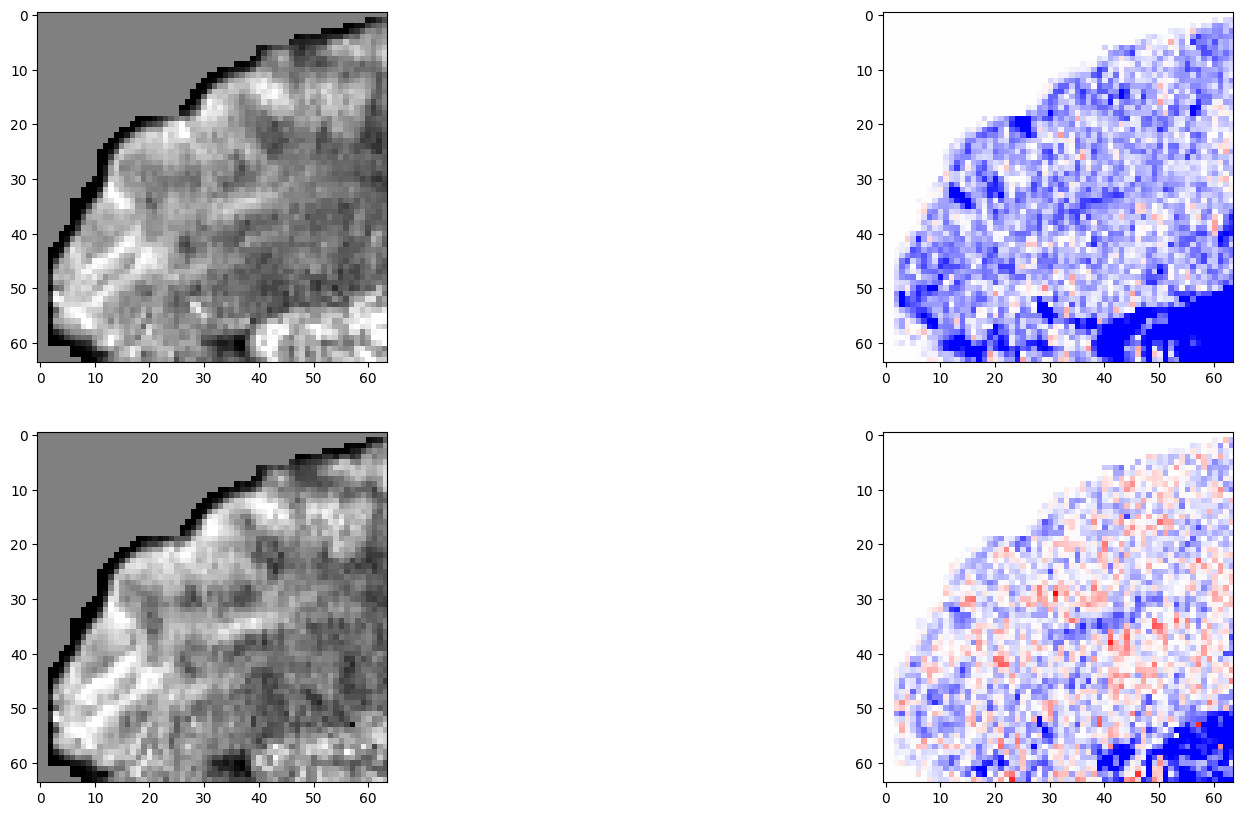

In [24]:
i=70
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)
axis[0][0].imshow(img_block_train[0, :, :, 30, 1], clim=(-2., 2.), cmap='gray')
axis[0][1].imshow(imgres_block_train[0, :, :, 30, 1], clim=(-1., 1.), cmap='bwr')
axis[1][0].imshow(img_block_val[0, :, :, 30, 1], clim=(-2., 2.), cmap='gray')
axis[1][1].imshow(imgres_block_val[0, :, :, 30, 1], clim=(-1., 1.), cmap='bwr')

In [28]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [26]:
nlayer = 10; 
nfilter = 128;
nin = 7; # should be 9 if t1w and t2w data are included
nout = 7; 

dpRoot = os.path.dirname(os.path.abspath('s_DeepDTI_trainCNN.py'));
dncnn = dncnn_model(nin, nout, layer_num=nlayer, filter_num=nfilter, kinit_type='he_normal', bnorm_flag=True);
dncnn.summary()

# %% set up adam optimizer

adam_opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0);
dncnn.compile(loss = qtlib.mean_squared_error_weighted, optimizer = adam_opt);
# qtlib.mean_squared_error_weighted is a custom loss function that weights the loss from each voxel
# in this example, only the loss within the brain mask
    
# %% train DnCNN model

nbatch = 1; # should adapte to different datasets and GPUs
nepoch = 100; # should adapte to different datasets, train for 100 epochs in this example

fnCp = 'deepdti_nb1_ep' + np.str(nepoch)
fpCp = os.path.join(dpRoot, fnCp + '.h5') 
checkpoint = ModelCheckpoint(fpCp, monitor='val_loss', save_best_only = True)

history = dncnn.fit(x = [img_block_train, mask_block_train], 
                    y = imgres_block_train, 
                    validation_data = ([img_block_val, mask_block_val], imgres_block_val),
                    batch_size = nbatch, 
                    epochs = nepoch, 
                    callbacks = [checkpoint],
                    verbose = 1, 
                    shuffle = True) 
                    
# save loss
fpLoss = os.path.join(dpRoot, fnCp + '.mat') 
sio.savemat(fpLoss, {'loss_train':history.history['loss'], 'loss_val':history.history['val_loss']})    


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 7)]                                                        
                                                                                                  
 conv1 (Conv3D)                 (None, None, None,   24320       ['input_3[0][0]']                
                                None, 128)                                                        
                                                                                                  
 conv2 (Conv3D)                 (None, Non

                                None, 7)                                                          
                                                                                                  
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 concatenate_1 (Concatenate)    (None, None, None,   0           ['conv10[0][0]',                 
                                None, 8)                          'input_4[0][0]']                
                                                                                                  
Total params: 3,592,583
Trainable params: 3,590,535
Non-trainable params: 2,048
__________________________________________________________________________________________________


/tmp/ipykernel_3021460/2666298760.py:22: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fnCp = 'deepdti_nb1_ep' + np.str(nepoch)


Epoch 1/100
48/48 [==============================] - 283s 6s/step - loss: 0.5525 - val_loss: 0.5427
Epoch 2/100
19/48 [==========>...................] - ETA: 2:42 - loss: 0.3159

KeyboardInterrupt: 

In [ ]:
# display loss
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.ylim([0, 0.1])

In [ ]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].imshow(img_block_val[0, :, :, 30, 1], clim=(-2., 2.), cmap='gray')
axis[1].imshow(img_block_pred[0, :, :, 30, 1], clim=(-2., 2.), cmap='gray')
axis[2].imshow(img_block_gt[0, :, :, 30, 1], clim=(-2., 2.), cmap='gray')
# display input, output and ground-truth images



In [ ]:
# %% apply DnCNN model

imgres_block_pred = dncnn.predict([img_block_val, mask_block_val]); # predicted residual images
imgres_block_pred = imgres_block_pred[:, :, :, :, :-1] * mask_block_val; # remove last channel
img_block_pred = (img_block_val + imgres_block_pred) * mask_block_val; # denoised images
img_block_gt = img_block_val + imgres_block_val[:, :, :, :, :-1]; # ground-truth images




In [ ]:
i=70
f, axis = plt.subplots(1, 2)
f.set_figwidth(20)
f.set_figheight(10)
# display residual images and report mean absolute difference
axis[0].imshow(imgres_block_val[0, :, :, 30, 1], clim=(-1., 1.), cmap='bwr')
axis[1].imshow(img_block_gt[0, :, :, 30, 1] - img_block_pred[0, :, :, 30, 1], clim=(-1., 1.), cmap='bwr')



In [ ]:
print(np.mean(np.abs(imgres_block_val[0, :, :, 30, 1]))) # mean absolute difference
print(np.mean(np.abs(img_block_gt[0, :, :, 30, 1] - img_block_pred[0, :, :, 30, 1])))